# Setup

## Install Detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 274 kB 6.2 MB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44074 sha256=2e99655f36b7c6c9d793773ea549adb68cbe6515fd4a9ade21180d4b6917946e
  Stored in directory: /home/shabanza/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.7.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-x8w82efd
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x8w82efd
     |████████

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
torch:  1.10 ; cuda:  cu113
detectron2: 0.6


## Install Mask2Former

In [2]:
# clone and install Mask2Former
# !git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
%pip install -U opencv-python
# %pip install git+https://github.com/cocodataset/panopticapi.git
%pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install

/scratch/shabanza/segmentation/Mask2Former
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 61.7 MB 6.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.3 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 108.1 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 8.1 MB/s s eta 0:00:01
     |████████████████████████████████| 1.3 MB 78.4 MB/s eta 0:00:01
     |████████████████████████████████| 268 kB 96.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
Note: you may need to restart the kernel to use updated packages.
/scratch/shabanza/segmentation/

In [3]:
%cd /scratch/shabanza/segmentation/Mask2Former
%cd mask2former/modeling/pixel_decoder/ops
!sudo sh make.sh
%cd /scratch/shabanza/segmentation/Mask2Former

/scratch/shabanza/segmentation/Mask2Former
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops
running build
running build_py
running build_ext
building 'MultiScaleDeformableAttention' extension
Emitting ninja build file /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
g++ -pthread -shared -B /opt/conda/compiler_compat -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib -Wl,--no-as-needed -Wl,--sysroot=/ /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/vision.o /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segment

For gccxx not found error:
> sudo apt-get update

> sudo apt-get install software-properties-common

> sudo add-apt-repository ppa:ubuntu-toolchain-r/test

> sudo apt-get upgrade libstdc++6

For libGL error:
> sudo apt-get install ffmpeg libsm6 libxext6  -y

## Imports

In [1]:
# import some common libraries
import os
import cv2
import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from IPython.display import display
from IPython.display import Image as dis_image

from detectron2.utils.visualizer import Visualizer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.empty_cache()

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
%cd Mask2Former
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former import add_maskformer2_config

/scratch/shabanza/segmentation/Mask2Former


# Model

In [5]:
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("configs/coco/instance-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_100ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_e5f453.pkl'

cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
predictor = DefaultPredictor(cfg)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/23 15:36:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_e5f453.pkl ...


model_final_e5f453.pkl: 866MB [00:03, 233MB/s]                               


WARNING [08/23 15:36:31 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


# Dataset

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from src.dataset.register_comic_instance import *

registering comic ...
loading sinergia json ...
Sinergia Json loaded.
registering placid ...


100%|██████████| 47256/47256 [00:00<00:00, 680390.89it/s]


registering yves ...


100%|██████████| 47256/47256 [00:00<00:00, 676528.82it/s]


In [7]:
dataset_name = DATASET_NAME

dataset_dicts = DatasetCatalog.get(dataset_name)
metadata = MetadataCatalog.get(dataset_name)

[08/23 15:36:49 d2.data.datasets.coco]: Loading /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_default_modified.json takes 1.40 seconds.
[08/23 15:36:49 d2.data.datasets.coco]: Loaded 282 images in COCO format from /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_default_modified.json


In [8]:
placid_dataset_dicts = DatasetCatalog.get(PLACID_NAME)
placid_metadata = MetadataCatalog.get(PLACID_NAME)

[08/23 15:36:51 d2.data.datasets.coco]: Loading /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_placid.json takes 1.63 seconds.
[08/23 15:36:51 d2.data.datasets.coco]: Loaded 154 images in COCO format from /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_placid.json


In [9]:
yves_dataset_dicts = DatasetCatalog.get(YVES_NAME)
yves_metadata = MetadataCatalog.get(YVES_NAME)

[08/23 15:36:52 d2.data.datasets.coco]: Loaded 128 images in COCO format from /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_yves.json


# Finetune

In [10]:
from src.evaluation.instance_evaluation import *
from src.evaluation.semantic_evaluation import *
from src.evaluation.helpers import *

from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
import copy
from copy import deepcopy
from tqdm import tqdm

## Placid

### Augmentations

In [11]:
# Customize the augmentation pipeline by adding desired transformations

transform_list = [
    T.RandomRotation(angle=(-10, 10)),  # Randomly rotate the image by -10 to +10 degrees
    T.RandomBrightness(0.8, 1.8),
    T.RandomContrast(0.6, 1.3),
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
]

augs = T.AugmentationList(transform_list)

In [12]:
for dic in placid_dataset_dicts:
    if dic['image_id'] == 223:
        test = deepcopy(dic)

### Increase Dataset Size

In [13]:
def comic_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    image, transforms = T.apply_transform_gens(transform_list, image)
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    dataset_dict["annotations"] = annos
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
        
    dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
    return dataset_dict


def augment_dataset(dataset_dicts):
    # Apply data augmentation to increase the dataset size
    augmented_dataset = []
    for sample in tqdm(dataset_dicts):
        new_sample = comic_mapper(sample)
        augmented_dataset.append(new_sample)
    
    return augmented_dataset


# Combine the original dataset with augmented dataset
# combined_dataset = augment_dataset(placid_dataset_dicts, apply_transform=False) + augment_dataset(placid_dataset_dicts)

### Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_dataset, test_dataset = train_test_split(placid_dataset_dicts, test_size=0.2, random_state=42)

In [16]:
def register_subset_dataset(dataset, new_name, eval_type, metadata):
    DatasetCatalog.register(new_name, lambda: dataset)
    new_metadata = MetadataCatalog.get(new_name)
    new_metadata.json_file = metadata.json_file
    new_metadata.evaluator_type = eval_type
    new_metadata.thing_dataset_id_to_contiguous_id = metadata.thing_dataset_id_to_contiguous_id
    new_metadata.thing_classes = metadata.thing_classes

In [17]:
new_train_name = f'{PLACID_NAME}_train'
comic_eval_type_sem = 'comic_sem_seg'
register_subset_dataset(train_dataset, new_train_name, comic_eval_type_sem, placid_metadata)

new_test_name = f'{PLACID_NAME}_test'
comic_eval_type_sem = 'comic_sem_seg'
register_subset_dataset(test_dataset, new_test_name, comic_eval_type_sem, placid_metadata)

In [18]:
MetadataCatalog.get(new_train_name)

namespace(name='sinergia_placid_instances_train',
          json_file='/sinergia/shabanza/datasets/sinergia/coco/annotations/instances_placid.json',
          evaluator_type='comic_sem_seg',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             12: 11,
                                             13: 12,
                                             14: 13,
                                             15: 14,
                                 

### Start Finetuning

In [19]:
import copy
import itertools
import logging
from collections import OrderedDict
from typing import Any, Dict, List, Set

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler
from detectron2.evaluation import DatasetEvaluators
from detectron2.solver.build import maybe_add_gradient_clipping
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.utils.events import EventStorage
from detectron2.evaluation import inference_on_dataset, print_csv_format

In [20]:
def compute_pixel_mean_std(dataset_dicts):
    pixel_values = []
    for dataset_dict in tqdm(dataset_dicts):
        image = cv2.imread(dataset_dict['file_name'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pixel_values.extend(image.reshape(-1, 3))
    return np.mean(pixel_values, axis=0), np.std(pixel_values, axis=0)

In [21]:
cfg.DATASETS.TRAIN = (new_train_name,)
cfg.DATASETS.TEST = (new_test_name, )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 28
cfg.SOLVER.OPTIMIZER = 'SGD'
cfg.OUTPUT_DIR = '/sinergia/shabanza/outputs/'

In [22]:
cfg.MODEL.PIXEL_MEAN = [184.70014834, 158.68679797, 118.3750071]
cfg.MODEL.PIXEL_STD = [45.54069698, 40.70228227, 40.9410987]

In [23]:
class ComicTrainer(DefaultTrainer):
    """
    Extension of the Trainer class adapted to MaskFormer.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each
        builtin dataset. For your own dataset, you can simply create an
        evaluator manually in your script and do not have to worry about the
        hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = cfg.OUTPUT_DIR
        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        # semantic segmentation
        if evaluator_type == 'comic_instance':
            evaluator_list.append(ComicInstanceEvaluator(dataset_name))
        # instance segmentation
        if evaluator_type == 'comic_sem_seg':
            evaluator_list.append(ComicSemanticEvaluator(dataset_name))
        
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=comic_mapper)

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)

    @classmethod
    def build_optimizer(cls, cfg, model):
        weight_decay_norm = cfg.SOLVER.WEIGHT_DECAY_NORM
        weight_decay_embed = cfg.SOLVER.WEIGHT_DECAY_EMBED

        defaults = {}
        defaults["lr"] = cfg.SOLVER.BASE_LR
        defaults["weight_decay"] = cfg.SOLVER.WEIGHT_DECAY

        norm_module_types = (
            torch.nn.BatchNorm1d,
            torch.nn.BatchNorm2d,
            torch.nn.BatchNorm3d,
            torch.nn.SyncBatchNorm,
            # NaiveSyncBatchNorm inherits from BatchNorm2d
            torch.nn.GroupNorm,
            torch.nn.InstanceNorm1d,
            torch.nn.InstanceNorm2d,
            torch.nn.InstanceNorm3d,
            torch.nn.LayerNorm,
            torch.nn.LocalResponseNorm,
        )

        params: List[Dict[str, Any]] = []
        memo: Set[torch.nn.parameter.Parameter] = set()
        for module_name, module in model.named_modules():
            for module_param_name, value in module.named_parameters(recurse=False):
                if not value.requires_grad:
                    continue
                # Avoid duplicating parameters
                if value in memo:
                    continue
                memo.add(value)

                hyperparams = copy.copy(defaults)
                if "backbone" in module_name:
                    hyperparams["lr"] = hyperparams["lr"] * cfg.SOLVER.BACKBONE_MULTIPLIER
                if (
                    "relative_position_bias_table" in module_param_name
                    or "absolute_pos_embed" in module_param_name
                ):
                    print(module_param_name)
                    hyperparams["weight_decay"] = 0.0
                if isinstance(module, norm_module_types):
                    hyperparams["weight_decay"] = weight_decay_norm
                if isinstance(module, torch.nn.Embedding):
                    hyperparams["weight_decay"] = weight_decay_embed
                params.append({"params": [value], **hyperparams})

        def maybe_add_full_model_gradient_clipping(optim):
            # detectron2 doesn't have full model gradient clipping now
            clip_norm_val = cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE
            enable = (
                cfg.SOLVER.CLIP_GRADIENTS.ENABLED
                and cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model"
                and clip_norm_val > 0.0
            )

            class FullModelGradientClippingOptimizer(optim):
                def step(self, closure=None):
                    all_params = itertools.chain(*[x["params"] for x in self.param_groups])
                    torch.nn.utils.clip_grad_norm_(all_params, clip_norm_val)
                    super().step(closure=closure)

            return FullModelGradientClippingOptimizer if enable else optim

        optimizer_type = cfg.SOLVER.OPTIMIZER
        if optimizer_type == "SGD":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.SGD)(
                params, cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM
            )
        elif optimizer_type == "ADAMW":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.AdamW)(
                params, cfg.SOLVER.BASE_LR
            )
        else:
            raise NotImplementedError(f"no optimizer type {optimizer_type}")
        if not cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model":
            optimizer = maybe_add_gradient_clipping(cfg, optimizer)
        return optimizer

    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA.
        logger.info("Running inference with test-time augmentation ...")
        model = SemanticSegmentorWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res

In [25]:
# data_loader = ComicTrainer.build_train_loader(cfg)

[08/23 14:14:40 d2.data.build]: Removed 0 images with no usable annotations. 123 images left.
[08/23 14:14:40 d2.data.build]: Distribution of instances among all 28 categories:
|   category    | #instances   |   category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:----------:|:-------------|
| Generic Obj.. | 2712         |     Car      | 93           |    Bus     | 0            |
|    Bicycle    | 29           |  Motorbike   | 28           |  Airplane  | 22           |
|     Boat      | 41           |    Train     | 1            |   Chair    | 104          |
|     Sofa      | 61           |    Table     | 105          |   Plant    | 547          |
|      Cat      | 62           |     Dog      | 86           |    Cow     | 7            |
|     Horse     | 9            |    Sheep     | 0            |    Bird    | 54           |
| Generic Ani.. | 165          |   Building   | 302          | Background | 0            |
|   

In [24]:
model = ComicTrainer.build_model(cfg)

[08/23 15:37:04 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (

In [25]:
# freeze backbone

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.sem_seg_head.predictor.class_embed.parameters():
        param.requires_grad = True
    
    for param in model.sem_seg_head.predictor.mask_embed.parameters():
        param.requires_grad = True

In [28]:
batch = next(iter(data_loader))
batch

[{'file_name': '/sinergia/shabanza/datasets/sinergia/images/default/placid/Vaillant_0610_1957_01_20-01.png',
  'height': 2237,
  'width': 1601,
  'image_id': 247,
  'annotations': [{'iscrowd': 0,
    'bbox': array([ 183.37615394, 1746.37495706,  249.87275171, 1821.85982853]),
    'category_id': 21,
    'segmentation': [array([ 206.37308896, 1747.07112527,  211.78235548, 1746.98204286,
             218.22268076, 1747.55607268,  223.65417672, 1748.81680724,
             229.77677754, 1750.74625256,  234.25966488, 1755.74311369,
             238.04041498, 1759.40135489,  241.49240822, 1763.74510242,
             244.93880294, 1767.74889606,  247.04657774, 1772.45482693,
             248.48987724, 1777.50174545,  249.24327029, 1782.56002568,
             246.26510155, 1786.33957738,  243.60552637, 1789.42378876,
             241.28590508, 1792.50240161,  238.62529615, 1794.91653916,
             235.95468858, 1797.33084138,  232.98755223, 1801.78030223,
             230.66793095, 1804.8589

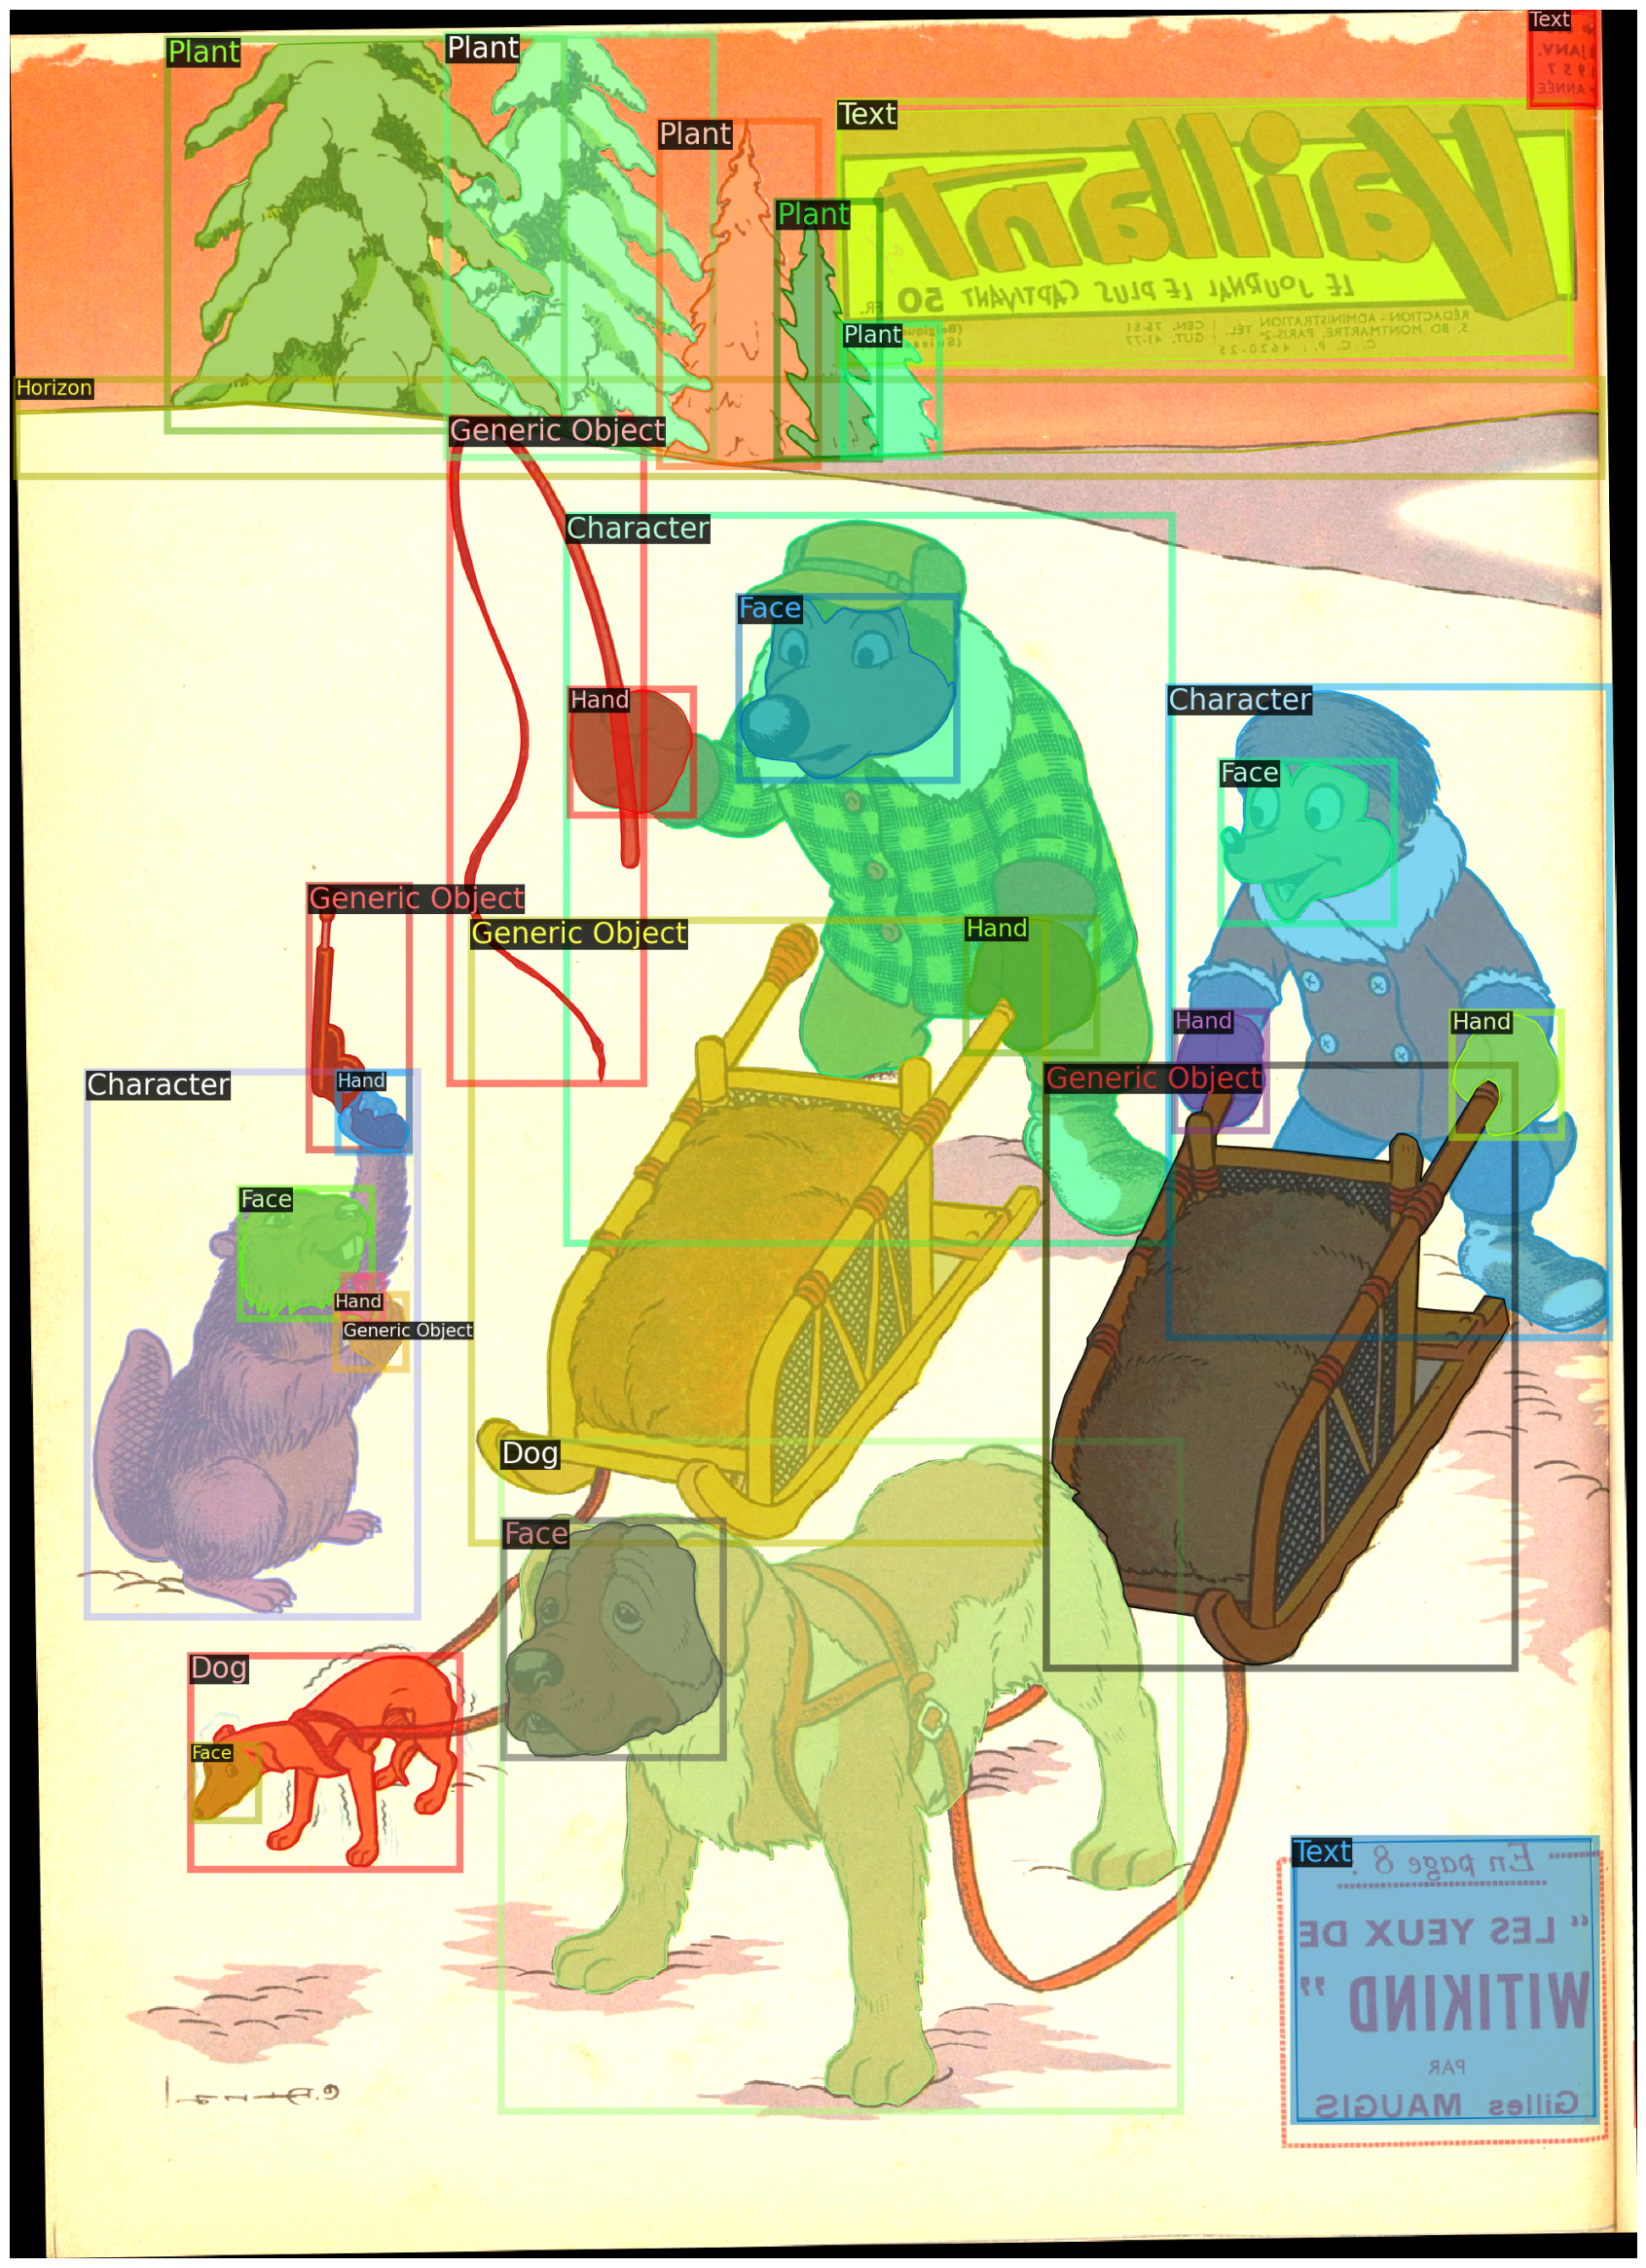

In [29]:
im = batch[0]["image"].cpu().numpy().transpose((1, 2, 0))
v = Visualizer(im, metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
r = v.draw_dataset_dict(batch[0]).get_image()
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(r)

In [26]:
logger = logging.getLogger("detectron2")


def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = ComicTrainer.get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results



def do_train(cfg, model, resume=True):
    model.train()
    freeze(model)
    optimizer = ComicTrainer.build_optimizer(cfg, model)
    scheduler = ComicTrainer.build_lr_scheduler(cfg, optimizer)

    checkpointer = DetectionCheckpointer(
        model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
    )
    start_iter = (
        checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
    )
    max_iter = cfg.SOLVER.MAX_ITER

    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
    )

    writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []
    data_loader = ComicTrainer.build_train_loader(cfg)
    logger.info("Starting training from iteration {}".format(start_iter))
    with EventStorage(start_iter) as storage:
        for data, iteration in tqdm(zip(data_loader, range(start_iter, max_iter))):
            storage.iter = iteration

            loss_dict = model(data)
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)
                
            print(f'Loss {losses_reduced}')

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            scheduler.step()

            if (
                cfg.TEST.EVAL_PERIOD > 0
                and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
                and iteration != max_iter - 1
            ):
                do_test(cfg, model)
                # Compared to "train_net.py", the test results are not dumped to EventStorage
                comm.synchronize()

            if iteration - start_iter > 5 and (
                (iteration + 1) % 20 == 0 or iteration == max_iter - 1
            ):
                for writer in writers:
                    writer.write()
            periodic_checkpointer.step(iteration)

In [27]:
do_train(cfg, model, resume=True)

WARNING [08/23 15:37:47 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[08/23 15:37:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_e5f453.pkl ...


WARNING [08/23 15:37:47 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...
[08/23 15:37:47 d2.data.build]: Removed 0 images with no usable annotations. 123 images left.
[08/23 15:37:47 d2.data.build]: Distribution of instances among all 28 categories:
|   category    | #instances   |   category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:----------:|:-------------|
| Generic Obj.. | 2712         |     Car      | 93           |    Bus     | 0            |
|    Bicycle    | 29           |  Motorbike   | 28           |  Airplane  | 22           |
|     Boat      | 41           |    Train     | 1            |   Chair    | 104          |
|     Sofa      | 61           |    Table     | 105          |   Plant    | 547          |
|      Cat      | 62           |     Dog      

0it [00:00, ?it/s]

Loss 231.48638212680817


2it [01:54, 57.28s/it]

Loss 205.79742062091827


3it [02:27, 46.39s/it]

Loss 234.6376382112503


4it [03:13, 45.93s/it]

Loss 193.1680766940117


5it [03:55, 44.63s/it]

Loss 197.0454992055893


6it [04:30, 41.24s/it]

Loss 252.6344633102417


7it [05:17, 43.21s/it]

Loss 211.0494500398636
Loss 230.41899800300598


9it [06:31, 39.85s/it]

Loss 245.66259932518005


10it [07:02, 37.05s/it]

Loss 221.85087877511978


11it [07:32, 34.98s/it]

Loss 229.53107792139053


12it [08:20, 38.79s/it]

Loss 201.3039150238037


13it [08:56, 38.18s/it]

Loss 215.07369422912598


14it [09:26, 35.66s/it]

Loss 237.29107427597046


15it [10:13, 38.89s/it]

Loss 206.90404278039932


16it [10:56, 40.19s/it]

Loss 217.30178648233414


17it [11:34, 39.69s/it]

Loss 215.0409735441208


18it [12:00, 35.32s/it]

Loss 208.45341020822525
Loss 221.6092699766159


19it [12:33, 34.75s/it]

Loss 201.37138509750366
[08/23 15:51:13 d2.utils.events]:  iter: 19  total_loss: 216.2  loss_ce: 18.19  loss_mask: 1.064  loss_dice: 4.151  loss_ce_0: 10.54  loss_mask_0: 0.6536  loss_dice_0: 4.03  loss_ce_1: 16.29  loss_mask_1: 0.8923  loss_dice_1: 4.129  loss_ce_2: 16.42  loss_mask_2: 0.9916  loss_dice_2: 4.162  loss_ce_3: 16.6  loss_mask_3: 1.054  loss_dice_3: 4.147  loss_ce_4: 16.94  loss_mask_4: 1.155  loss_dice_4: 4.159  loss_ce_5: 17.24  loss_mask_5: 1.187  loss_dice_5: 4.176  loss_ce_6: 17.66  loss_mask_6: 1.143  loss_dice_6: 4.152  loss_ce_7: 17.97  loss_mask_7: 1.094  loss_dice_7: 4.153  loss_ce_8: 18.03  loss_mask_8: 1.071  loss_dice_8: 4.157     lr: 0.00025  max_mem: 32558M


20it [13:26, 40.21s/it]

Loss 216.1377249211073


22it [14:20, 33.55s/it]

Loss 236.5113639831543
Loss 235.20570820569992


24it [15:30, 35.11s/it]

Loss 214.50552928447723
Loss 211.35233914852142


26it [16:47, 36.70s/it]

Loss 216.2221249639988


26it [17:10, 39.62s/it]


RuntimeError: CUDA out of memory. Tried to allocate 7.05 GiB (GPU 0; 39.45 GiB total capacity; 25.05 GiB already allocated; 3.59 GiB free; 33.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [31]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = ComicTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[08/23 14:11:19 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (

RuntimeError: CUDA out of memory. Tried to allocate 494.00 MiB (GPU 0; 39.45 GiB total capacity; 37.01 GiB already allocated; 68.31 MiB free; 37.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [30]:
torch.cuda.empty_cache()

# Evaluation

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(30, 30))
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [12]:
from src.evaluation.instance_evaluation import *
from src.evaluation.semantic_evaluation import *
from src.evaluation.helpers import *
from src.dataset.register_comic_instance import COMIC_CLASS_ID2CATEGORY

#### Sample: Instance - Page

In [166]:
new_train_name

'sinergia_placid_instances_train5'

In [168]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator

In [174]:
evaluator = COCOEvaluator(new_train_name, output_dir=output, distributed=False)
evaluator.reset()
im = test['image'].cpu().numpy().transpose((1, 2, 0))[:,:,::-1]
outputs = predictor(im)
evaluator.process([test], [outputs])
metrics = evaluator.evaluate([test['image_id']])
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use 

[08/18 13:35:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...


AssertionError: A prediction has class=59, but the dataset only has 28 classes and predicted class id should be in [0, 27].

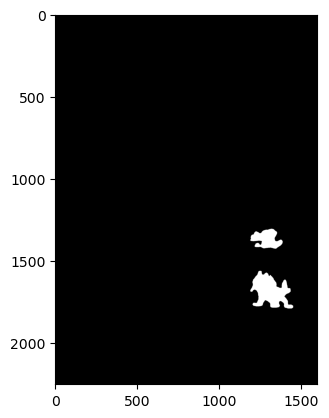

In [107]:
plt.imshow(outputs['instances'].pred_masks[0].cpu().numpy(), cmap="gray")  # Use "cmap" to specify the colormap (e.g., "gray" for grayscale)

#### Sample: Instance - Panel

In [108]:
evaluator2 = ComicInstanceEvaluator(PLACID_NAME)
outputs = predictor(panels[9])
evaluator.process([sample], [outputs], cropped_box=cropped_boxes[9])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use 

mean_iou 0.004674913543733477
iou_per_class:
Generic Object: 0.06738789484328946
Car: 0.0
Bus: 0.0
Bicycle: 0.0
Motorbike: 0.0
Airplane: 0.0
Boat: 0.0
Train: 0.0
Chair: 0.0
Sofa: 0.0
Table: 0.0
Plant: 0.0
Cat: 0.0
Dog: 0.0
Cow: 0.0
Horse: 0.0
Sheep: 0.0
Bird: 0.0
Generic Animal: 0.0
Building: 0.0
Background: 0.0
Face: 0.0
Hand: 0.0
Horizon: 0.0
Panel: 0.0
Comic Bubble: 0.0
Text: 0.0
Character: 0.06350968438124789


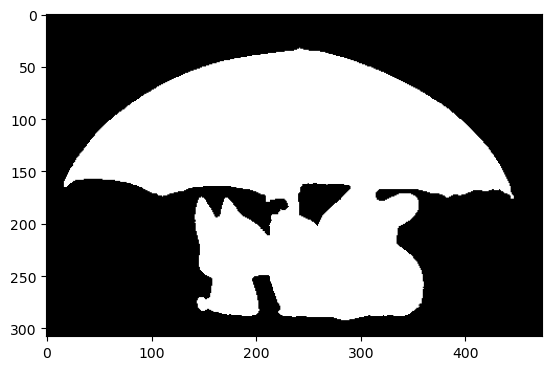

In [109]:
plt.imshow(outputs['instances'].pred_masks[0].cpu().numpy(), cmap="gray")

#### Sample: Semantic - Page

In [110]:
evaluator = ComicSemanticEvaluator(PLACID_NAME)
im = cv2.imread(sample['file_name'])
outputs = predictor(im)
evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use 

100%|██████████| 175/175 [00:06<00:00, 28.52it/s]

mean_iou 0.2702753554255774
iou_per_class:
Generic Object: 0.0689627194289338
Car: 0.0
Bus: 0.0
Bicycle: 0.0
Motorbike: 0.0
Airplane: 0.0
Boat: 0.0
Train: 0.0
Chair: 0.38617643289753767
Sofa: 0.0
Table: 0.0
Plant: 0.48551703164958726
Cat: 0.0
Dog: 0.0
Cow: 0.0
Horse: 0.0
Sheep: 0.0
Bird: 0.0
Generic Animal: 0.0
Building: 0.7587840670603226
Background: 0.0
Face: 0.8980409253991434
Hand: 0.8946624455831509
Horizon: 0.7757962875394097
Panel: 0.8149494351452435
Comic Bubble: 0.6771455749443307
Text: 0.9096341068693655
Character: 0.8980409253991434


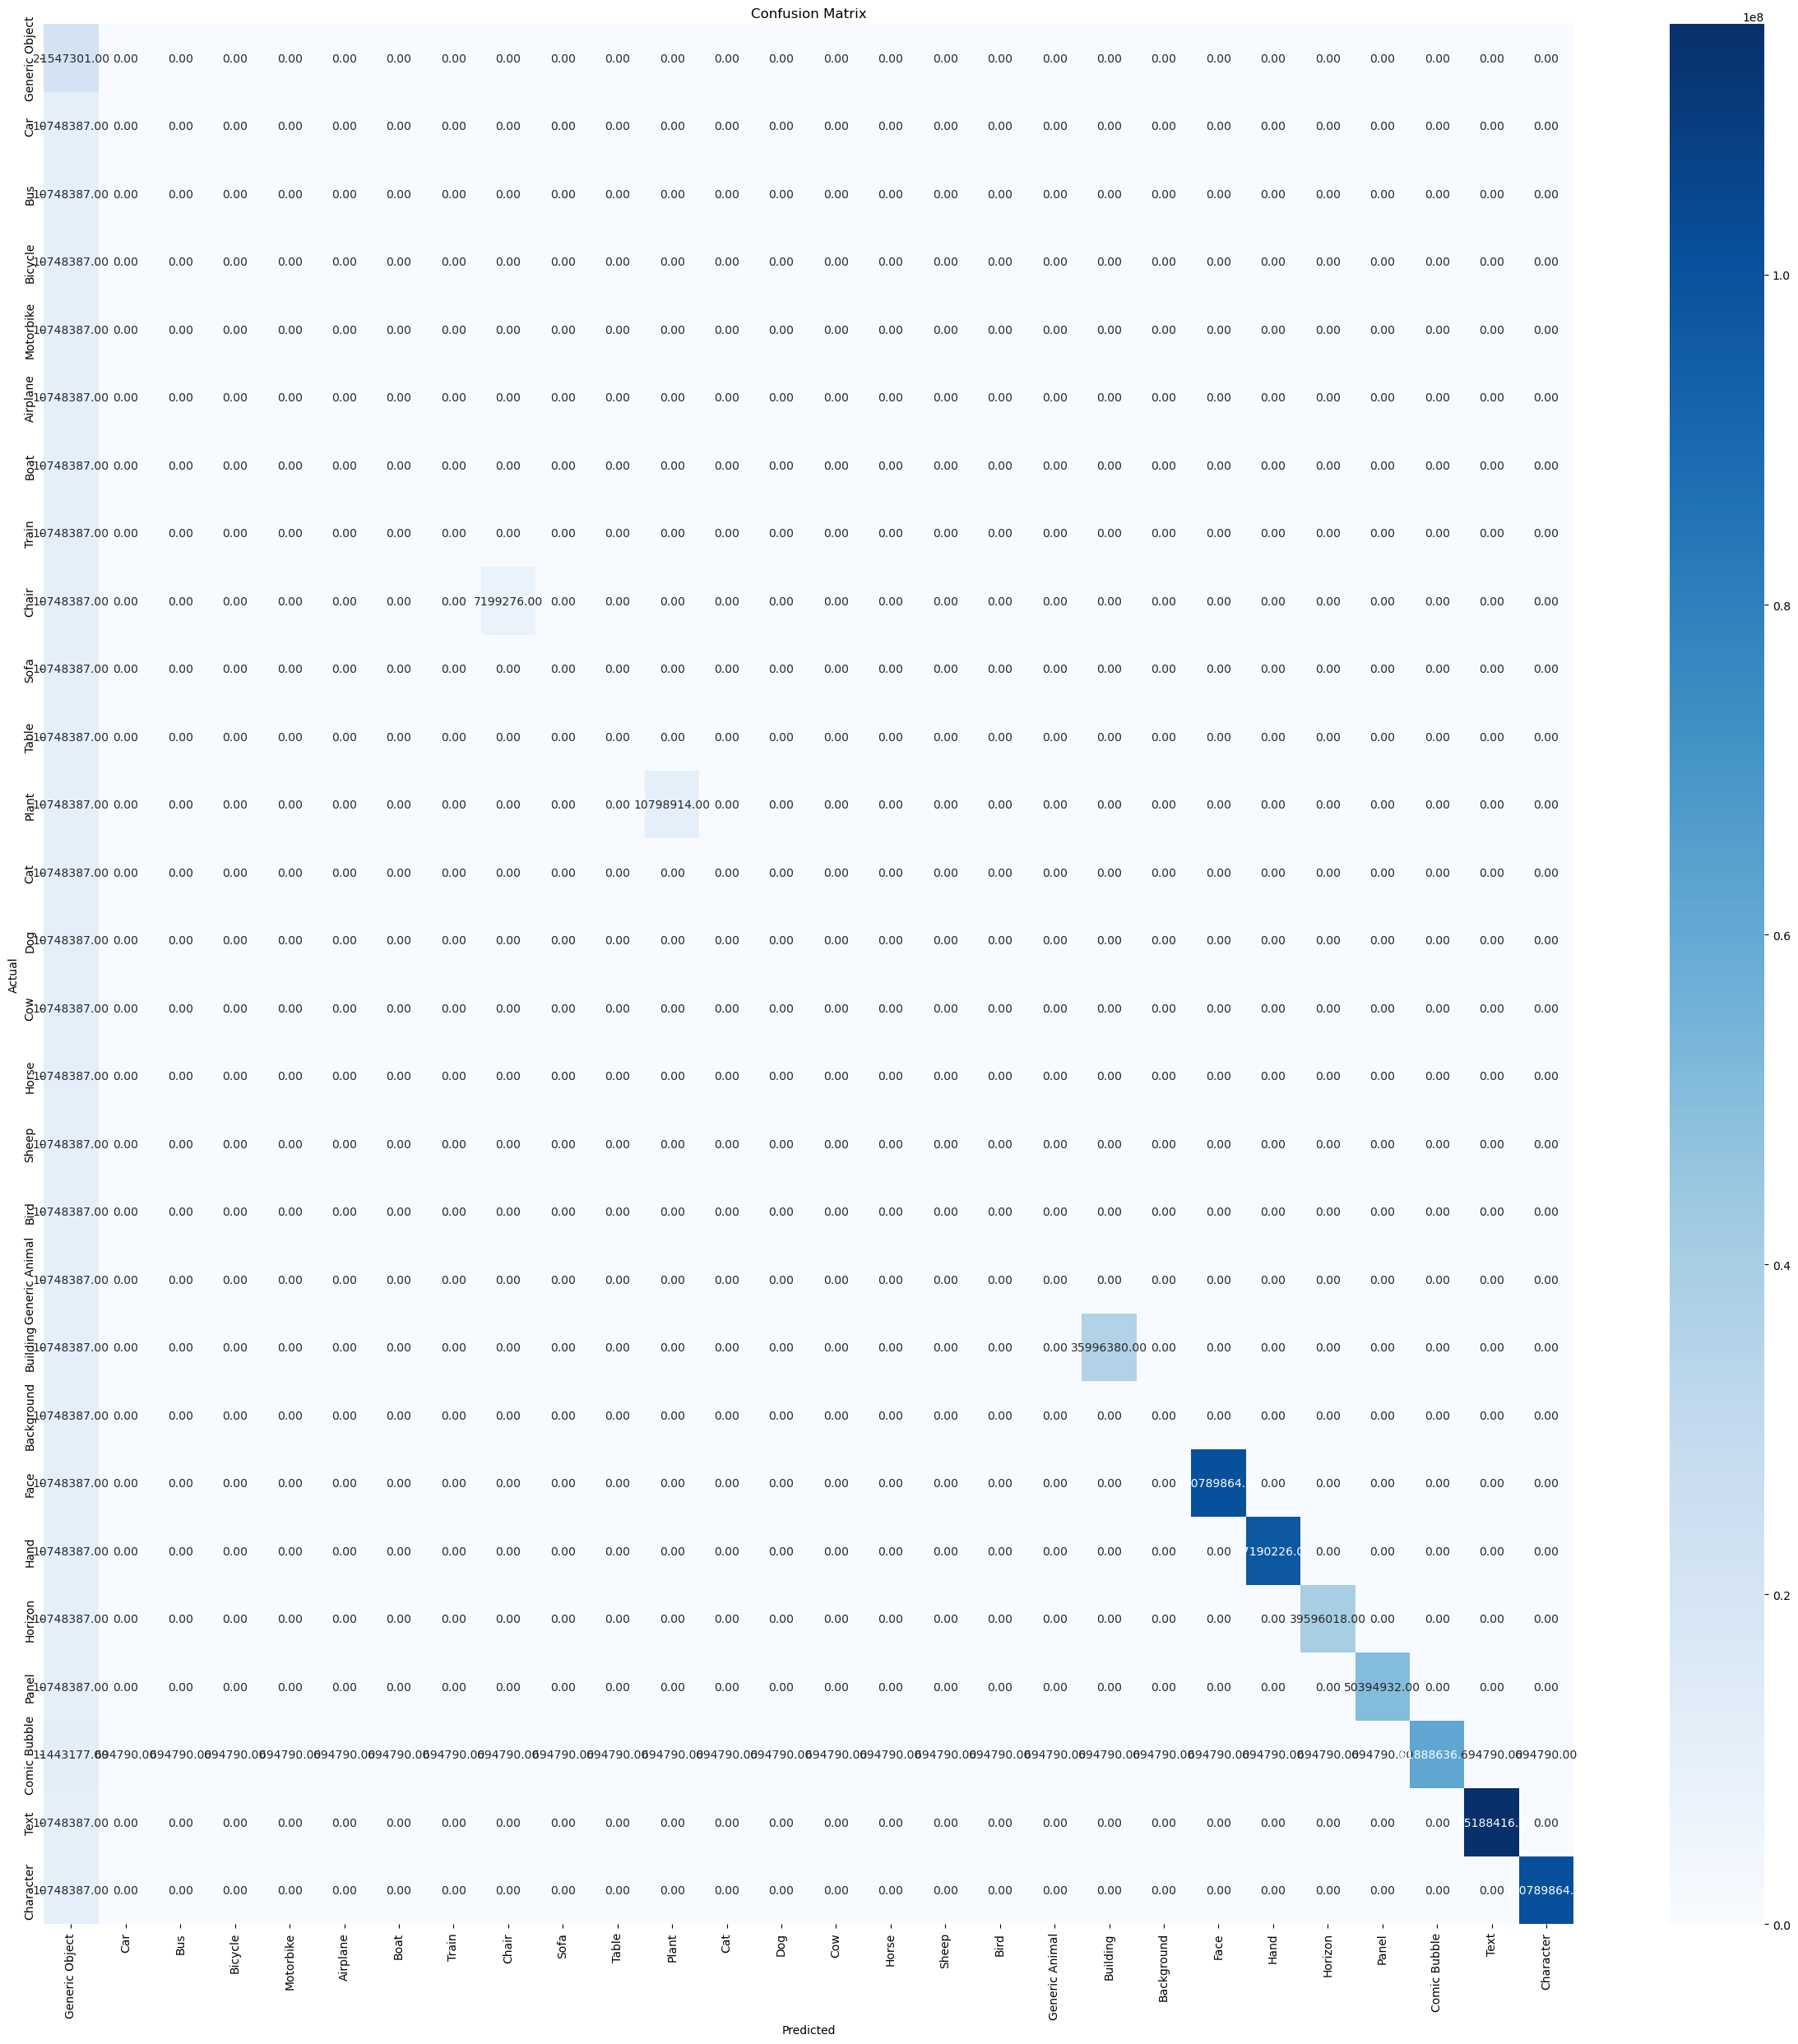

In [111]:
plot_confusion_matrix(evaluator.confusion_matrix, [k['name'] for k in COMIC_CATEGORIES])

#### Sample: Semantic - Panel

In [112]:
evaluator = ComicSemanticEvaluator(PLACID_NAME)
im = cv2.imread(sample['file_name'])
outputs = predictor(im)
evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use 

mean_iou 0.2702753554255774
iou_per_class:
Generic Object: 0.0689627194289338
Car: 0.0
Bus: 0.0
Bicycle: 0.0
Motorbike: 0.0
Airplane: 0.0
Boat: 0.0
Train: 0.0
Chair: 0.38617643289753767
Sofa: 0.0
Table: 0.0
Plant: 0.48551703164958726
Cat: 0.0
Dog: 0.0
Cow: 0.0
Horse: 0.0
Sheep: 0.0
Bird: 0.0
Generic Animal: 0.0
Building: 0.7587840670603226
Background: 0.0
Face: 0.8980409253991434
Hand: 0.8946624455831509
Horizon: 0.7757962875394097
Panel: 0.8149494351452435
Comic Bubble: 0.6771455749443307
Text: 0.9096341068693655
Character: 0.8980409253991434


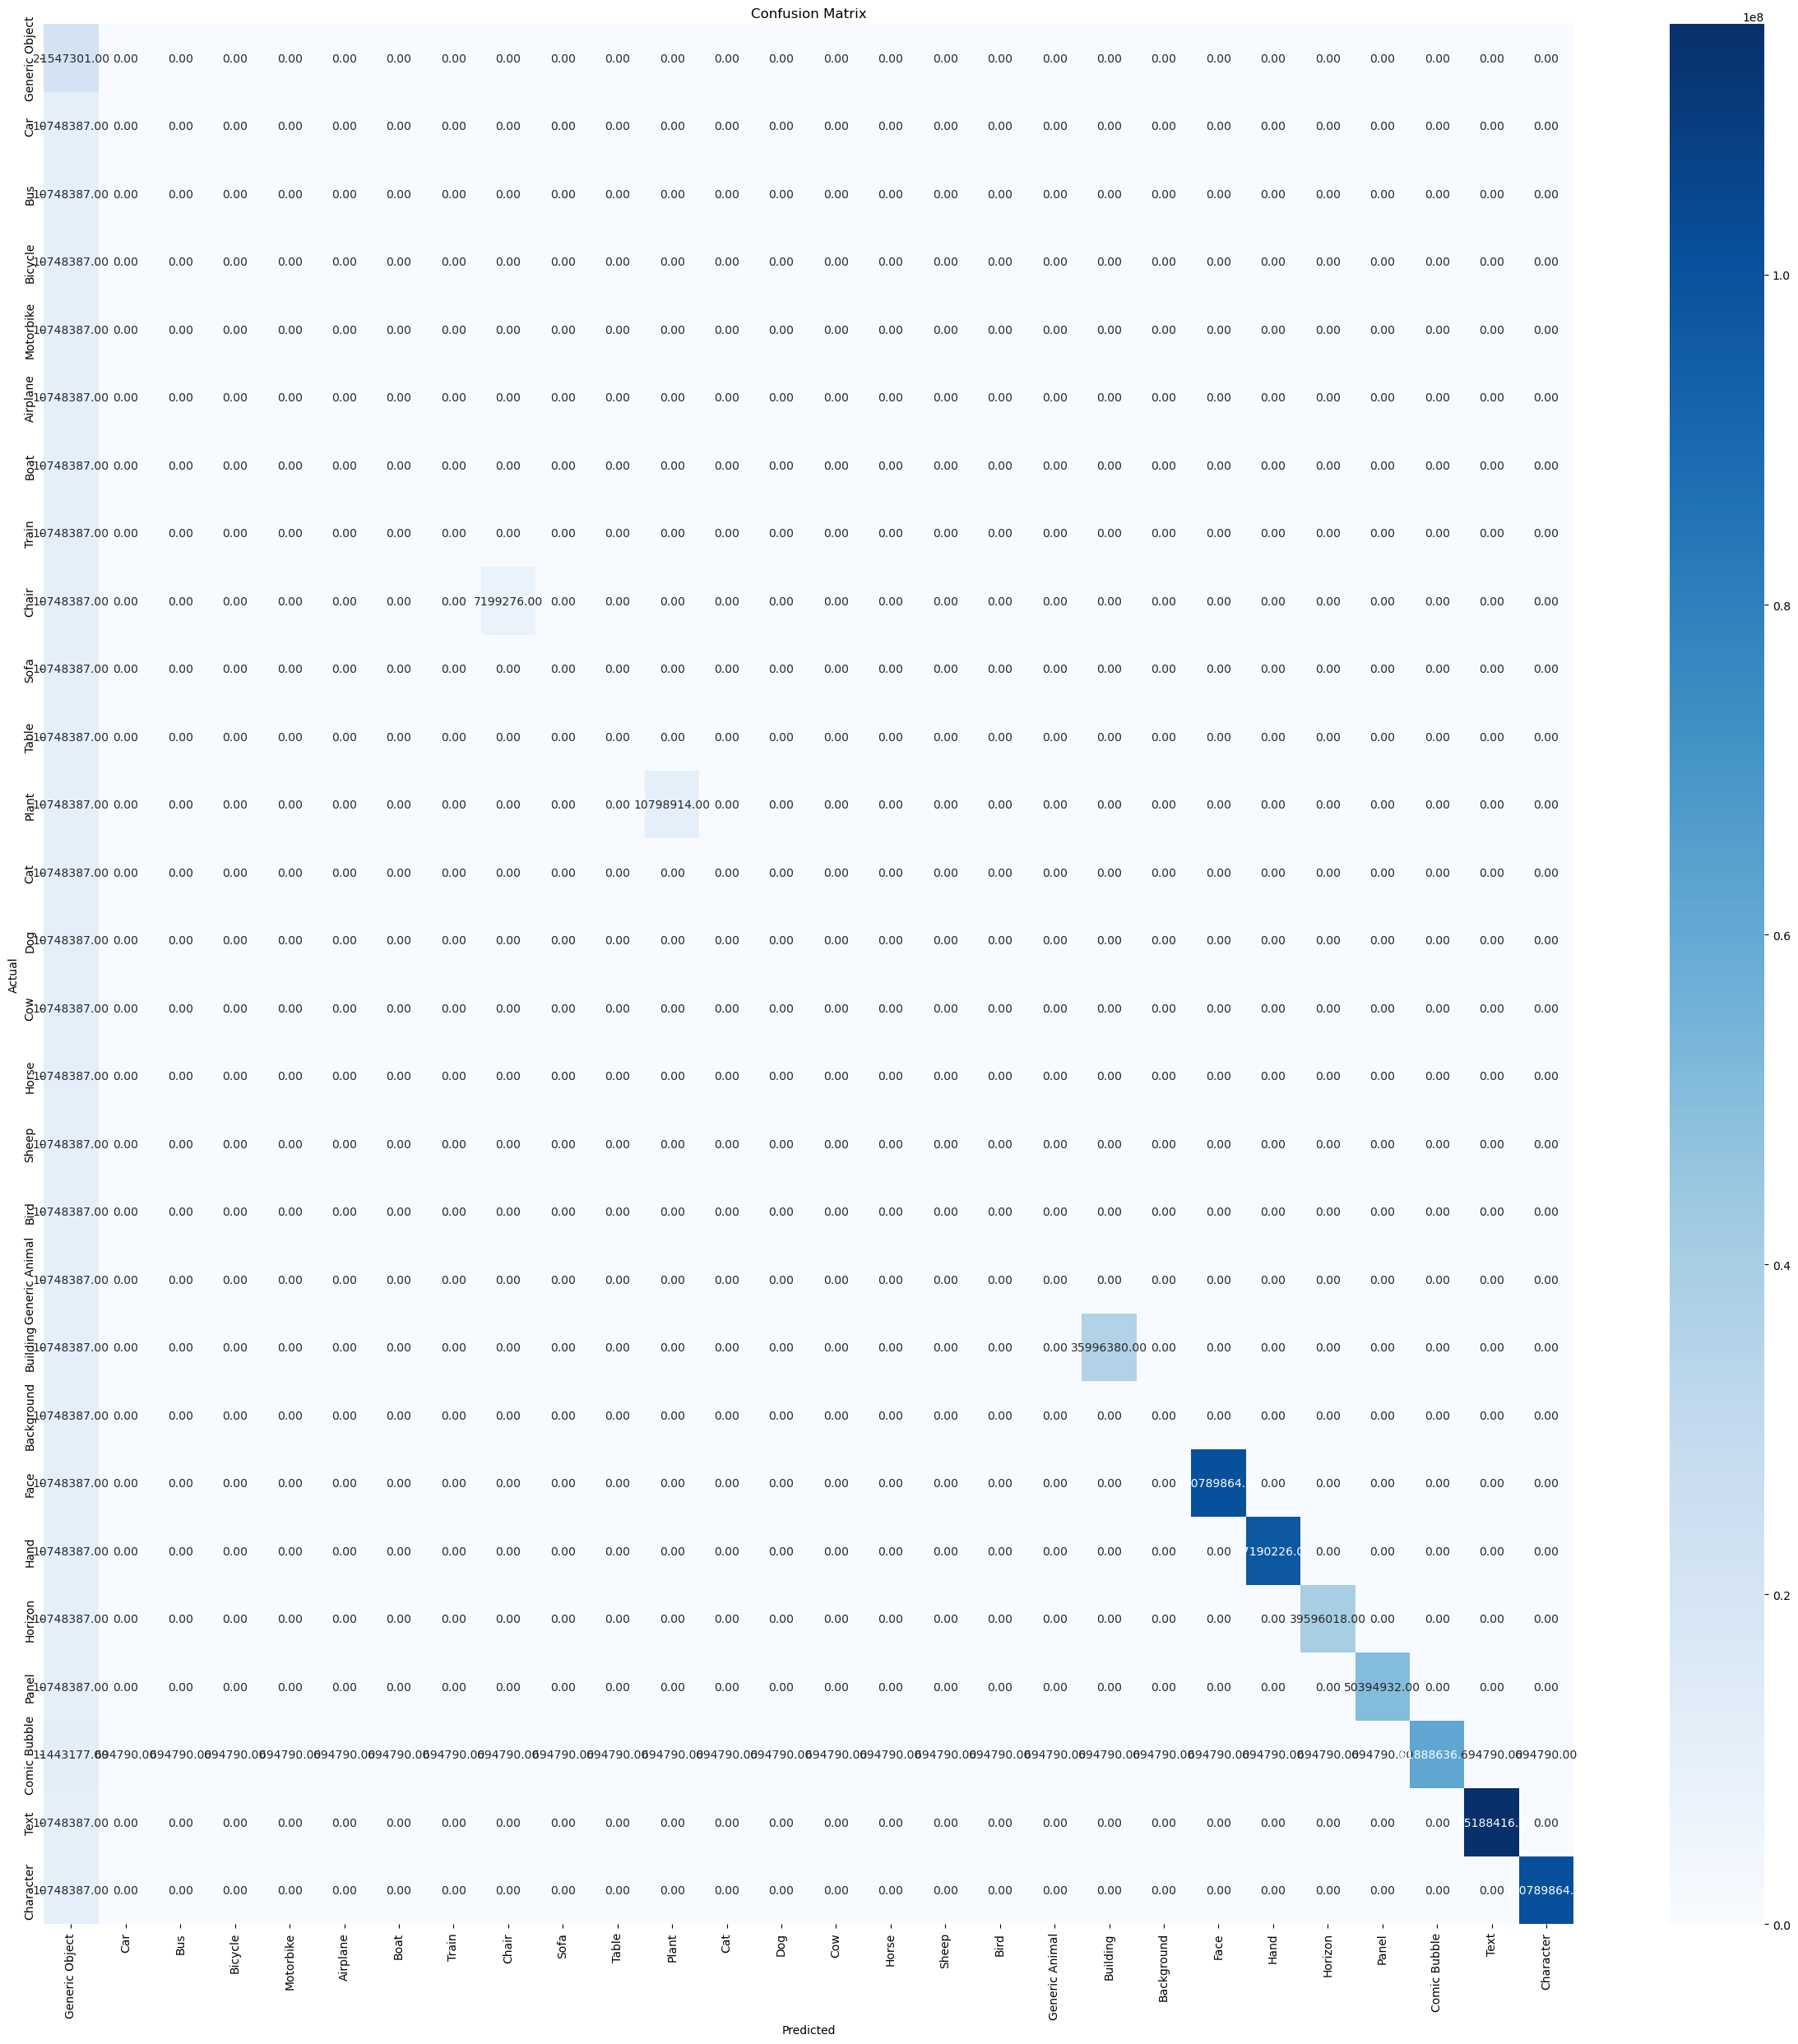

In [113]:
plot_confusion_matrix(evaluator.confusion_matrix, [k['name'] for k in COMIC_CATEGORIES])

### Semantic: Page-Wise

In [13]:
for dic in placid_dataset_dicts:
    if dic['image_id'] == 129:
        test = dic

In [19]:
evaluator = ComicSemanticEvaluator(PLACID_NAME)
for sample in tqdm(placid_dataset_dicts[:20]):
    im = cv2.imread(sample['file_name'])
    outputs = predictor(im)
    evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

  0%|          | 0/20 [00:00<?, ?it/s]

Problem in annotations image_id = 129 in class 24!
Problem in annotations image_id = 129 in class 24!


Problem in annotations image_id = 129 in class 24!


  5%|▌         | 1/20 [00:04<01:23,  4.37s/it]

Problem in annotations image_id = 130 in class 24!


Problem in annotations image_id = 130 in class 24!


 10%|█         | 2/20 [00:09<01:22,  4.56s/it]

Problem in annotations image_id = 131 in class 24!
Problem in annotations image_id = 131 in class 24!


 15%|█▌        | 3/20 [00:14<01:27,  5.13s/it]

Problem in annotations image_id = 132 in class 24!


Problem in annotations image_id = 132 in class 24!


 25%|██▌       | 5/20 [00:25<01:18,  5.22s/it]

Problem in annotations image_id = 133 in class 24!
Problem in annotations image_id = 133 in class 24!


 35%|███▌      | 7/20 [00:34<01:01,  4.71s/it]

Problem in annotations image_id = 136 in class 24!


100%|██████████| 20/20 [01:34<00:00,  4.71s/it]

mean_iou 0.1529232129026085
iou_per_class:
Generic Object: 0.06892339642175738
Car: 0.035004723691465345
Bus: 0.008256307918802719
Bicycle: 0.0
Motorbike: 0.0457383412889815
Airplane: 0.0
Boat: 0.021762955746518795
Train: 0.0
Chair: 0.021746921243265587
Sofa: 0.002799531117650444
Table: 0.04505569073756717
Plant: 0.13729017091957618
Cat: 0.05261050705865328
Dog: 0.019191154502808616
Cow: 0.002830877909767308
Horse: 0.016748206815098463
Sheep: 0.0
Bird: 0.09131990059009513
Generic Animal: 0.04546477810054739
Building: 0.10710986268700193
Background: 0.0
Face: 0.6239654501773584
Hand: 0.6697647158107953
Horizon: 0.1865561630036795
Panel: 0.43790736184540097
Comic Bubble: 0.4606883127482303
Text: 0.5667809805354587
Character: 0.6143336504025578


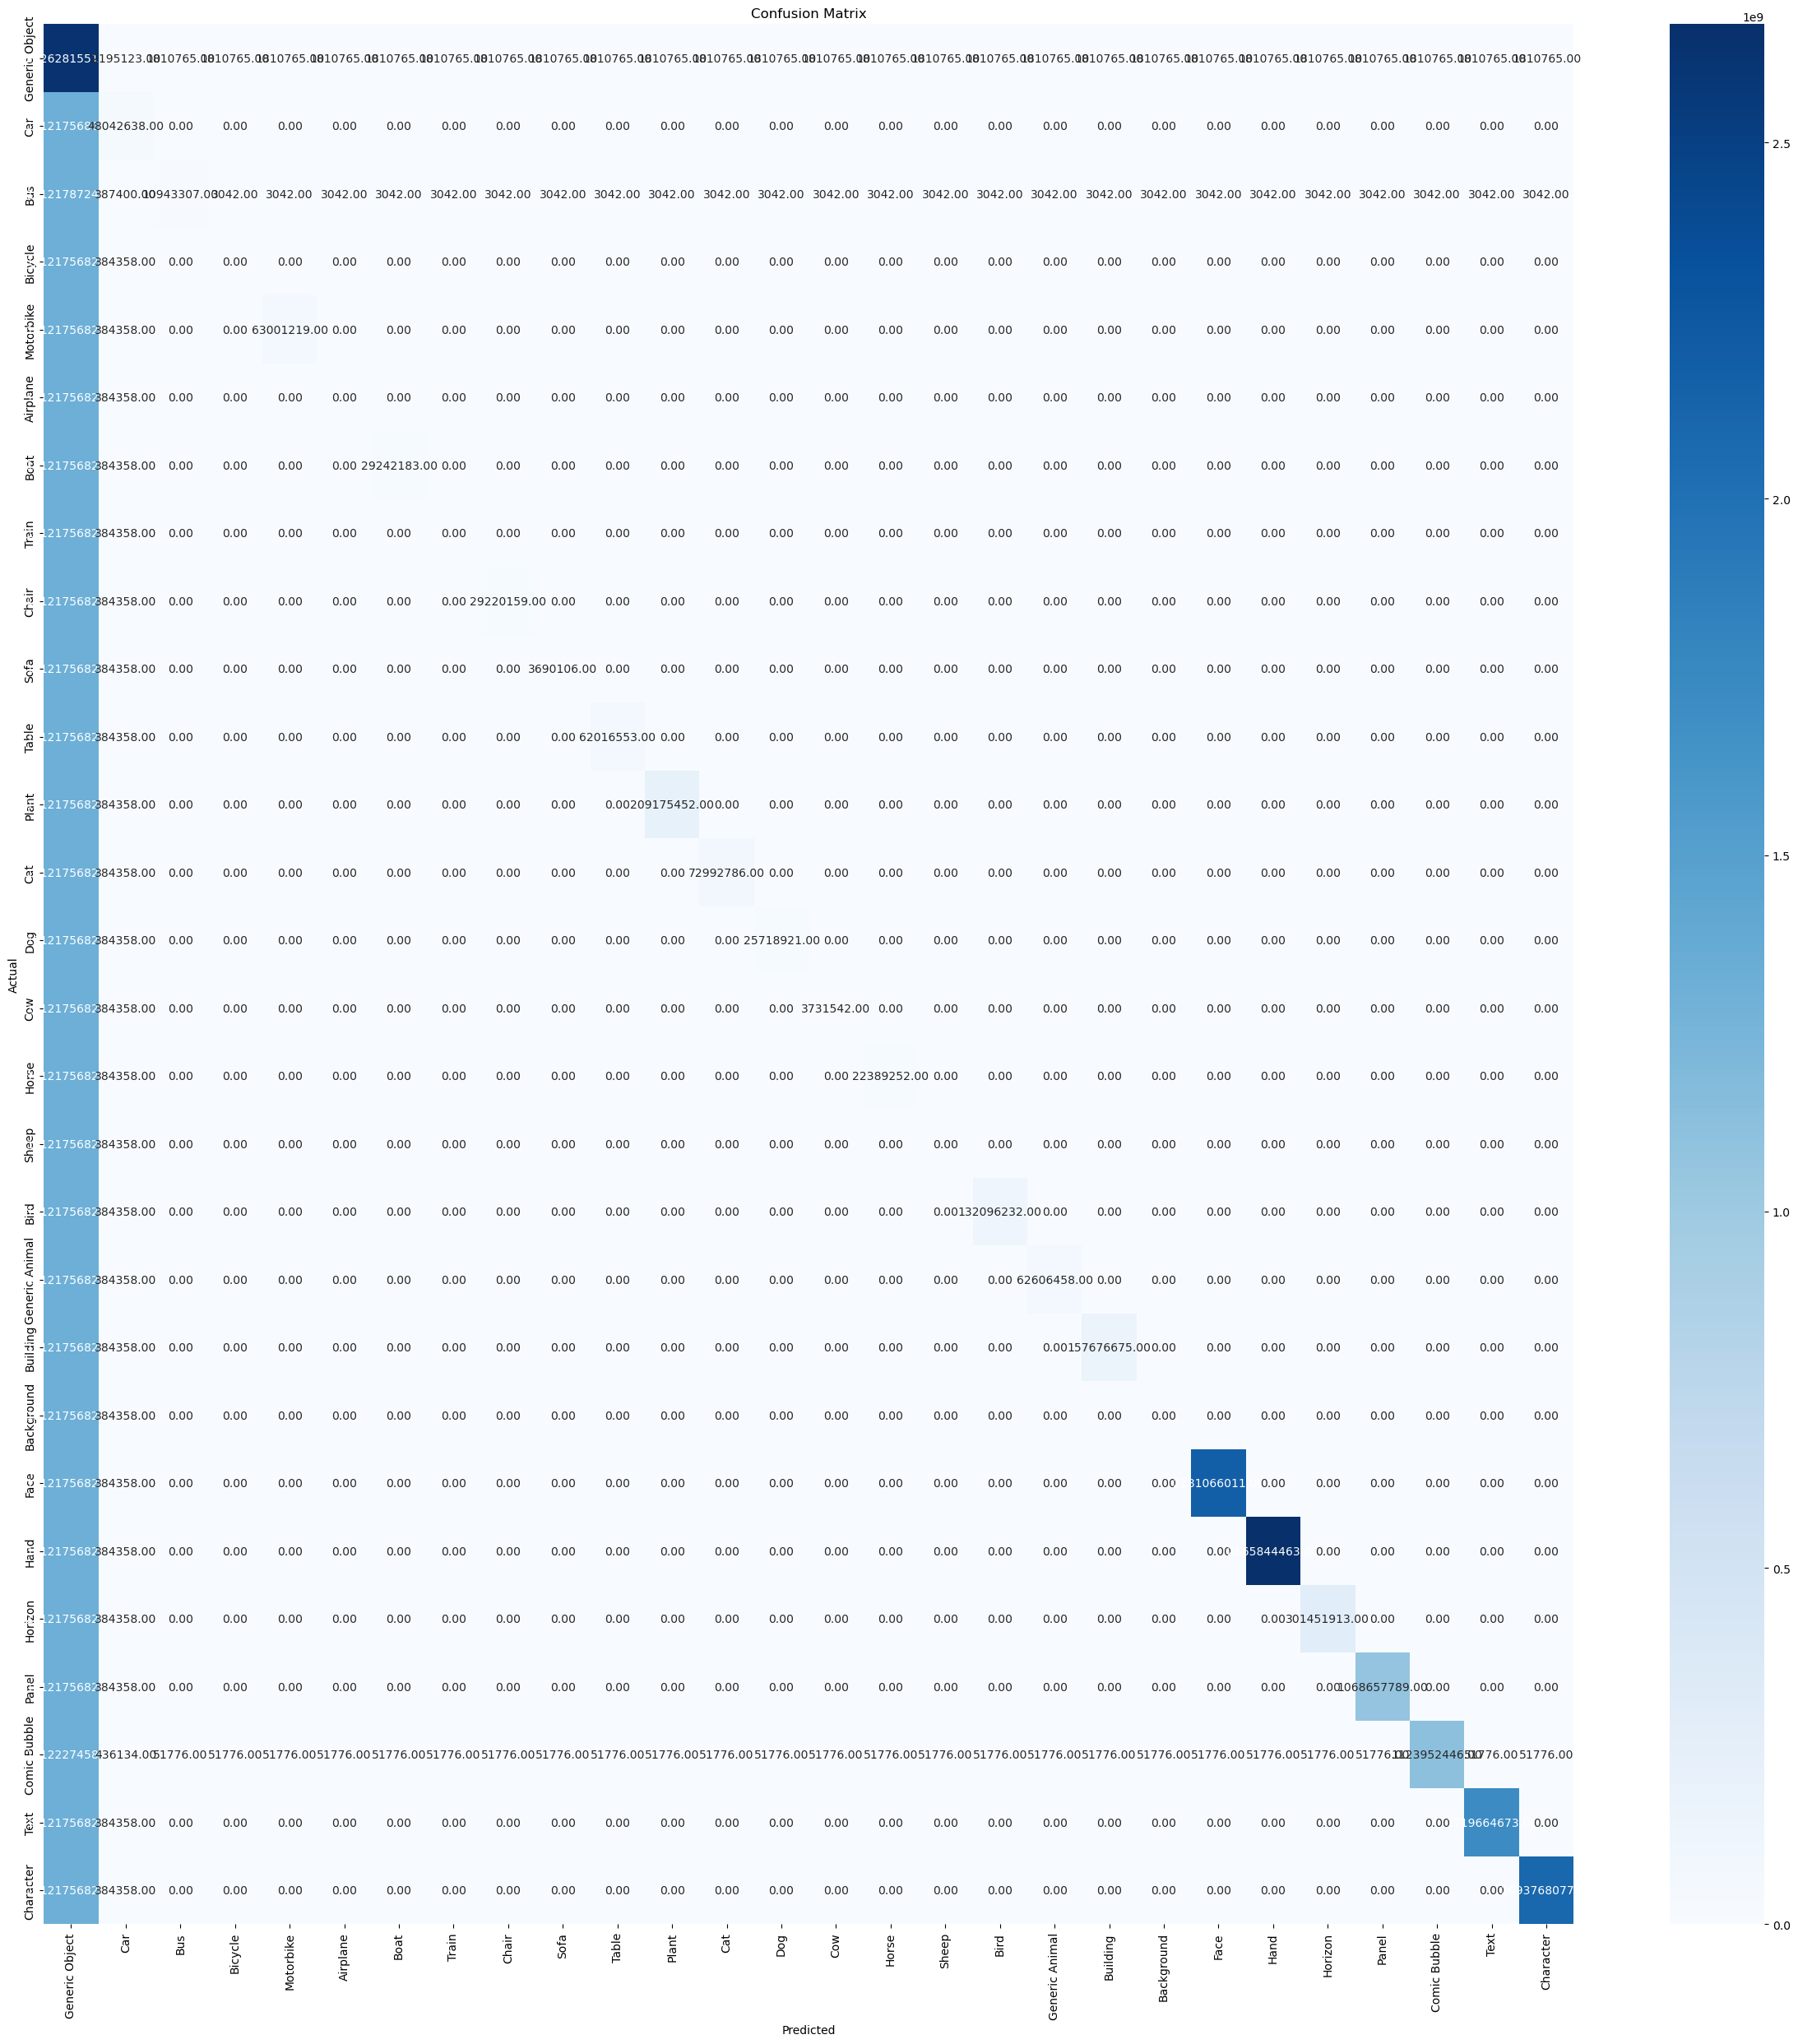

In [16]:
plot_confusion_matrix(evaluator.confusion_matrix, [k['name'] for k in COMIC_CATEGORIES])

Now add preprocessing to placid group:
 - median blur a little makes better
 - adaptive histogram equalization (MAKES BOTH BETTER, ESPECIALLY YVES)

In [47]:
evaluator = ComicSemanticEvaluator(PLACID_NAME)
for sample in tqdm(placid_dataset_dicts[:20]):
    im = cv2.imread(sample['file_name'])
    median = cv2.medianBlur(im, 5)
    outputs = predictor(median)
    evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

  0%|          | 0/20 [00:00<?, ?it/s]


Problem in annotations image_id = 129 in class 24!
Problem in annotations image_id = 129 in class 24!


 58%|█████▊    | 100/171 [00:02<00:01, 44.01it/s]

Problem in annotations image_id = 129 in class 24!


  5%|▌         | 1/20 [00:04<01:24,  4.45s/it]

Problem in annotations image_id = 130 in class 24!


Problem in annotations image_id = 130 in class 24!


 10%|█         | 2/20 [00:09<01:22,  4.61s/it]

Problem in annotations image_id = 131 in class 24!
Problem in annotations image_id = 131 in class 24!


 15%|█▌        | 3/20 [00:15<01:27,  5.18s/it]

Problem in annotations image_id = 132 in class 24!


Problem in annotations image_id = 132 in class 24!


 25%|██▌       | 5/20 [00:26<01:20,  5.38s/it]

Problem in annotations image_id = 133 in class 24!
Problem in annotations image_id = 133 in class 24!


 35%|███▌      | 7/20 [00:35<01:03,  4.86s/it]

Problem in annotations image_id = 136 in class 24!


100%|██████████| 20/20 [01:35<00:00,  4.76s/it]

mean_iou 0.15300056134822285
iou_per_class:
Generic Object: 0.06895880852138908
Car: 0.03504046555704664
Bus: 0.008288487046850384
Bicycle: 0.0
Motorbike: 0.04576011844848654
Airplane: 0.0
Boat: 0.0217735780945284
Train: 0.0
Chair: 0.021788962744145816
Sofa: 0.0028009240512822044
Table: 0.04509952690437295
Plant: 0.1373492641457256
Cat: 0.05263537574866782
Dog: 0.019200546210670008
Cow: 0.002832286395998062
Horse: 0.01675642342542135
Sheep: 0.0
Bird: 0.09142205838314715
Generic Animal: 0.04548643121841701
Building: 0.10726088209751247
Background: 0.0
Face: 0.6242034171892687
Hand: 0.6700158288604257
Horizon: 0.18669438386291648
Panel: 0.43817271968431754
Comic Bubble: 0.46084591280675175
Text: 0.5670496201006142
Character: 0.6145796962522835


Now adaptive histogram equalization

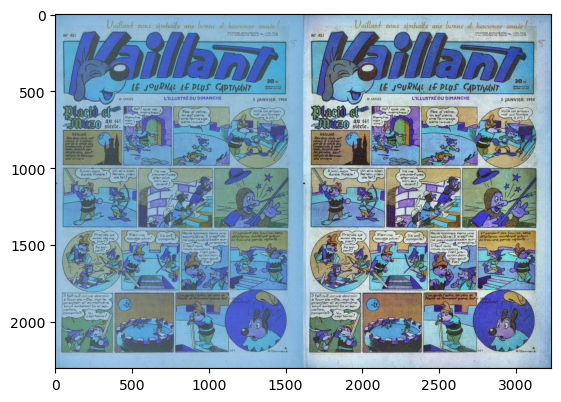

In [14]:
image = cv2.imread(test['file_name'])  # Read the image in grayscale

# Apply adaptive histogram equalization
b, g, r = cv2.split(image)

# Apply adaptive histogram equalization to each color channel
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized_b = clahe.apply(b)
equalized_g = clahe.apply(g)
equalized_r = clahe.apply(r)

# Merge the equalized color channels back into an image
equalized_image = cv2.merge([equalized_b, equalized_g, equalized_r])
compare = np.concatenate((image, equalized_image), axis=1) #side by side comparison

plt.imshow(compare)

In [21]:
evaluator = ComicSemanticEvaluator(PLACID_NAME)
for sample in tqdm(placid_dataset_dicts[:20]):
    im = cv2.imread(sample['file_name'])
    b, g, r = cv2.split(im)

    # Apply adaptive histogram equalization to each color channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_b = clahe.apply(b)
    equalized_g = clahe.apply(g)
    equalized_r = clahe.apply(r)

    # Merge the equalized color channels back into an image
    equalized_image = cv2.merge([equalized_b, equalized_g, equalized_r])
    outputs = predictor(equalized_image)
    evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

  0%|          | 0/20 [00:00<?, ?it/s]

Problem in annotations image_id = 129 in class 24!
Problem in annotations image_id = 129 in class 24!


Problem in annotations image_id = 129 in class 24!


  5%|▌         | 1/20 [00:04<01:31,  4.83s/it]

Problem in annotations image_id = 130 in class 24!


Problem in annotations image_id = 130 in class 24!


 10%|█         | 2/20 [00:09<01:27,  4.88s/it]

Problem in annotations image_id = 131 in class 24!
Problem in annotations image_id = 131 in class 24!


 15%|█▌        | 3/20 [00:16<01:36,  5.65s/it]

Problem in annotations image_id = 132 in class 24!


Problem in annotations image_id = 132 in class 24!


 25%|██▌       | 5/20 [00:27<01:23,  5.55s/it]

Problem in annotations image_id = 133 in class 24!
Problem in annotations image_id = 133 in class 24!


 35%|███▌      | 7/20 [00:37<01:06,  5.12s/it]

Problem in annotations image_id = 136 in class 24!


100%|██████████| 20/20 [01:42<00:00,  5.11s/it]

mean_iou 0.153063823083748
iou_per_class:
Generic Object: 0.06898137971071601
Car: 0.03505469957845833
Bus: 0.008264886739394295
Bicycle: 0.0
Motorbike: 0.04577848003126368
Airplane: 0.0
Boat: 0.02178253460801437
Train: 0.0
Chair: 0.021814633886644754
Sofa: 0.0028020985605740067
Table: 0.045149235037351514
Plant: 0.13739908486804195
Cat: 0.05265634384711664
Dog: 0.01920846509611722
Cow: 0.0028334740190692456
Horse: 0.01676335150954142
Sheep: 0.0
Bird: 0.09154280054011542
Generic Animal: 0.04550468821910979
Building: 0.10733045330601491
Background: 0.0
Face: 0.6243585405543309
Hand: 0.670175327986678
Horizon: 0.1867700412688703
Panel: 0.4383587491661712
Comic Bubble: 0.4612680113356286
Text: 0.5672507070135564
Character: 0.6147390594621651


In [23]:
evaluator = ComicSemanticEvaluator(YVES_NAME)
for sample in tqdm(yves_dataset_dicts[:20]):
    im = cv2.imread(sample['file_name'])
    outputs = predictor(im)
    evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

100%|██████████| 20/20 [01:23<00:00,  4.17s/it]

mean_iou 0.16856992290784673
iou_per_class:
Generic Object: 0.06856119224087695
Car: 0.0
Bus: 0.0
Bicycle: 0.0
Motorbike: 0.0
Airplane: 0.0
Boat: 0.0051516358698363756
Train: 0.0
Chair: 0.010342385822238204
Sofa: 0.0
Table: 0.015523624523439422
Plant: 0.4836948201364691
Cat: 0.02541317330983829
Dog: 0.0
Cow: 0.0
Horse: 0.3145418817025701
Sheep: 0.0
Bird: 0.030191357740032967
Generic Animal: 0.2550924225985302
Building: 0.10978156709663063
Background: 0.0
Face: 0.6493068291404283
Hand: 0.6284518440900201
Horizon: 0.2744704502373142
Panel: 0.5110040323630906
Comic Bubble: 0.0
Text: 0.5947871121667476
Character: 0.7436435123816452


In [24]:
evaluator = ComicSemanticEvaluator(YVES_NAME)
for sample in tqdm(yves_dataset_dicts[:20]):
    im = cv2.imread(sample['file_name'])
    median = cv2.medianBlur(im, 5)
    outputs = predictor(median)
    evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]

mean_iou 0.16801369990844436
iou_per_class:
Generic Object: 0.0683217519999866
Car: 0.0
Bus: 0.0
Bicycle: 0.0
Motorbike: 0.0
Airplane: 0.0
Boat: 0.004942386132551842
Train: 0.0
Chair: 0.01030265747361891
Sofa: 0.0
Table: 0.015437643594421662
Plant: 0.48259771071851865
Cat: 0.02533852162902358
Dog: 0.0
Cow: 0.0
Horse: 0.31333881850453577
Sheep: 0.0
Bird: 0.030133457238545894
Generic Animal: 0.25423284456769163
Building: 0.10824995935448034
Background: 0.0
Face: 0.6473361512473536
Hand: 0.6266832989908395
Horizon: 0.2731406215991544
Panel: 0.5092929377047744
Comic Bubble: 0.0
Text: 0.593098823747647
Character: 0.7419360129332991


In [22]:
evaluator = ComicSemanticEvaluator(YVES_NAME)
for sample in tqdm(yves_dataset_dicts[:20]):
    im = cv2.imread(sample['file_name'])
    b, g, r = cv2.split(im)

    # Apply adaptive histogram equalization to each color channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_b = clahe.apply(b)
    equalized_g = clahe.apply(g)
    equalized_r = clahe.apply(r)

    # Merge the equalized color channels back into an image
    equalized_image = cv2.merge([equalized_b, equalized_g, equalized_r])
    outputs = predictor(equalized_image)
    evaluator.process([sample], [outputs])
metrics = evaluator.evaluate()
print("mean_iou", metrics["mean_iou"])
print("iou_per_class:")
for class_id, iou in metrics["iou_per_class"].items():
    print(f"{COMIC_CLASS_ID2CATEGORY[class_id + 1]}: {iou}")

100%|██████████| 20/20 [01:31<00:00,  4.56s/it]

mean_iou 0.16778511735508986
iou_per_class:
Generic Object: 0.06820708809697598
Car: 0.0
Bus: 0.0
Bicycle: 0.0
Motorbike: 0.0
Airplane: 0.0
Boat: 0.005039257329784877
Train: 0.0
Chair: 0.010285812975598023
Sofa: 0.0
Table: 0.015253505217536269
Plant: 0.4815106695866615
Cat: 0.024758967548844064
Dog: 0.0
Cow: 0.0
Horse: 0.3113562626023671
Sheep: 0.0
Bird: 0.030092958402871794
Generic Animal: 0.2539376975764522
Building: 0.10905115631899502
Background: 0.0
Face: 0.6468911698066331
Hand: 0.6262622738863762
Horizon: 0.2724233929106318
Panel: 0.5087704725974456
Comic Bubble: 0.0
Text: 0.59240052308562
Character: 0.7417420779997228
